## Three-dimensional hyperbolic systems

### Navier Stokes equation in 3d

First we are going to study the three-dimensional Navier-Stokes equation 
\begin{align}
    \frac{\partial}{\partial t} n &= - \nabla\cdot\left( nu\vec { b}\right) \\
    \frac{\partial}{\partial t} u &= - \nabla_\parallel\left(\frac{u^2}{2}\right) - \frac{\tau}{\mu} \frac{\nabla_\parallel n}{n} + \nu_u \frac{\Delta_\parallel u}{n}
\end{align}
with
\begin{align}
\Delta_\parallel u &= \nabla\cdot ( \vec {b}\vec {b}\cdot\nabla u)
\end{align} 
$\vec {b} = \vec {b}(\vec x)$ is the prescribed magnetic field unit vector,
and $\nu_u$ is the viscosity coefficient parallel to this field.

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
from scipy import ndimage

In [2]:
def create_inputfile() :
    inputfile = fp.load_calibration_default()
    inputfile["magnetic_field"]["params"] = mag.select("guenther.json")

    scaleR = [1.0,1.0]
    scaleZ = [1.0,1.0]
    inputfile["grid"] = {"Nx" : 32, "Ny" : 32, "Nz": 20, "n": 3,
                         "scaleR" : scaleR, "scaleZ" : scaleZ}
    inputfile["boundary"]["wall"] = {"type" : "none" }
    inputfile["boundary"]["sheath"] = {"type" : "none" }

    inputfile["init"] ={
        "type" : "fields",
        "density": {    
            "type" : "ne",
            "ntilde": {
#                 "type" : "circle", # secret init condition in Feltor
#                 "sigma" : 0.2,
                "type" : "blob",
                "sigma" : 0.1,
                "amplitude" : 1.0,
                "posX" : 0.5,
                "posY" : 0.0,
                "rk4eps" :1e-6,
                "revolutions" : 1,
                "parallel" : "double-step", # secret non-symmetric init condition
                "sigma_z" : 1
            },
            "profile" : {
                "type" : "const",
                "background" : 0.2
            },
            "damping": {
                "type" : "none"
            }
        },
        "potential" : {"type" : "zero_pol"},
        "velocity"  : {"type" : "zero"}, 
        "aparallel" : {"type" : "zero"}
    }
    inputfile["regularization"] = {
        "type" : "none",
        "direction" : "forward",
        "nu_perp_n" : 0,
        "nu_perp_u" : 0,
        "order" : 2,
        "jfactor" : 1
    }
    inputfile["source"] = {
        "minne" : 0.,
        "type" : "zero"
    }
    inputfile["timestepper"] = {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-4,
        "atol" : 1e-6,
        "output-mode" : "Tend",
        "reject-limit" : 2,
        "Tend" : 10
    }
    inputfile["FCI"]["periodify"] = False
    inputfile["advection"]= {
        "type"  : "staggered-fieldaligned",
        "slope-limiter" : "none"}
    inputfile["physical"]["tau"] = 1.0
    inputfile["physical"]["viscosity"] = "value"
    inputfile["physical"]["nu_parallel"] = [0,0]
    inputfile["output"] = {
        "type" : "netcdf",
        "itstp" : 100,
        "maxout" : 1,
        "compression" : [1,1]
    }
    return inputfile

inputfile = create_inputfile()
print("grid", json.dumps( inputfile["grid"], indent=4,sort_keys=True))
print("init", json.dumps( inputfile["init"], indent=4,sort_keys=True))
print("advection", json.dumps( inputfile["advection"], indent=4,sort_keys=True))

grid {
    "Nx": 32,
    "Ny": 32,
    "Nz": 20,
    "n": 3,
    "scaleR": [
        1.0,
        1.0
    ],
    "scaleZ": [
        1.0,
        1.0
    ]
}
init {
    "aparallel": {
        "type": "zero"
    },
    "density": {
        "damping": {
            "type": "none"
        },
        "ntilde": {
            "amplitude": 1.0,
            "parallel": "double-step",
            "posX": 0.5,
            "posY": 0.0,
            "revolutions": 1,
            "rk4eps": 1e-06,
            "sigma": 0.1,
            "sigma_z": 1,
            "type": "blob"
        },
        "profile": {
            "background": 0.2,
            "type": "const"
        },
        "type": "ne"
    },
    "potential": {
        "type": "zero_pol"
    },
    "type": "fields",
    "velocity": {
        "type": "zero"
    }
}
advection {
    "slope-limiter": "none",
    "type": "staggered-fieldaligned"
}


In [3]:
rep = simplesim.Manager( executable="./feltor.sh", directory="ThreeDimensional/calibrate", filetype="nc")

In [4]:
def plot( simulationfile):
    simfile = rep.create( simulationfile)
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    
    print( f"{simfile}")
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}")
    frows = 1
    fcols = 1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc, yc = np.meshgrid( x, y)
    
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*12,frows*9),dpi= 80, facecolor='w', edgecolor='k')
    im = ax.pcolormesh(xc, yc, ncin["lparallelinv_ta2d"][0,:,:],
                       vmin=-0.08, vmax=0.08,
                       cmap="seismic", shading="gouraud") 
    fig.colorbar(im, ax=ax)
    ax.axis("scaled")
    ax.set_xlabel( "R [mm]")
    ax.set_ylabel( "Z [mm]")
    plt.show()

### Fieldaligned derivatives
In this first experiment we initialize a disc in the plane at $\varphi=0$. 
Then, we transform the disc along the fieldlines half around the torus in both directions.
We can then apply the FCI derivative. Analytically $\nabla_\parallel f=0$ except at both ends of the disc
where the derivatives diverge.

In the following we see that this is not true numerically.

Running simulation f1d9a1...cb1390.nc
ThreeDimensional/calibrate/f1d9a105b7c90cd52f61dfdbdaf6647f63cb1390.nc
n: 3, Nx: 32, Nz: 20, mx: 1, method: dg


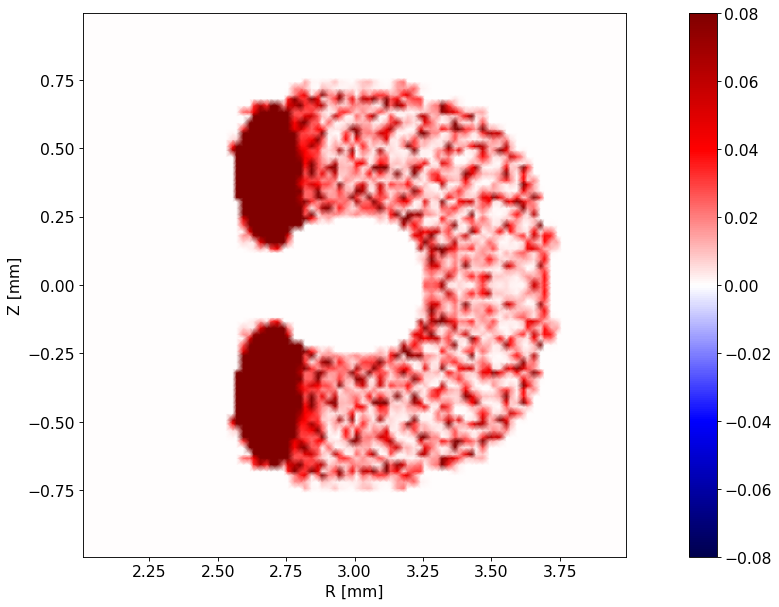

Running simulation 8e6b32...e91be7.nc
ThreeDimensional/calibrate/8e6b325018b8139a0c37dc8cd10cd6ce3ce91be7.nc
n: 3, Nx: 32, Nz: 20, mx: 10, method: dg


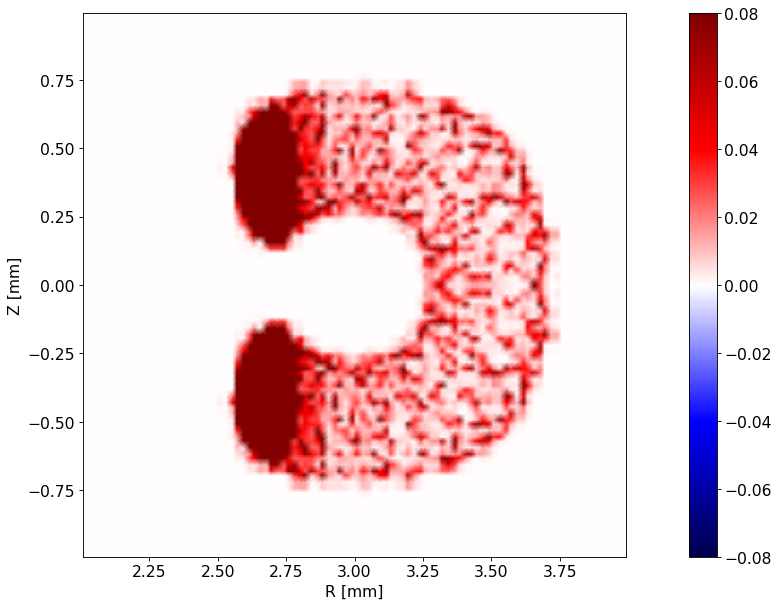

In [37]:
for method in ["dg"]:
    for mx in [1,10]:
        simulationfile = create_inputfile()
        simulationfile["flags"] = []
        simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
        simulationfile["init"]["density"]["ntilde"]["type"]="circle"
        simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
        simulationfile["output"]["maxout"] = 0
        simulationfile["advection"]["type"] = "centered"
        simulationfile["physical"]["nu_parallel"] = [0,1]
        simulationfile["FCI"]["refine"] = [mx,mx]
        simulationfile["FCI"]["interpolation-method"] = method
        simulationfile["grid"]["n"] = 3
        simulationfile["grid"]["Nx"] = 32
        simulationfile["grid"]["Ny"] = 32
        simulationfile["grid"]["Nz"] = 20
        plot(simulationfile)

We now change the interpolation method to a bi-linear one, hoping that
less oscillations appear.

Running simulation d94752...ff3371.nc
ThreeDimensional/calibrate/d947520dbf9f452a97bc0e4cae4bd14555ff3371.nc
n: 3, Nx: 32, Nz: 20, mx: 1, method: linear-const


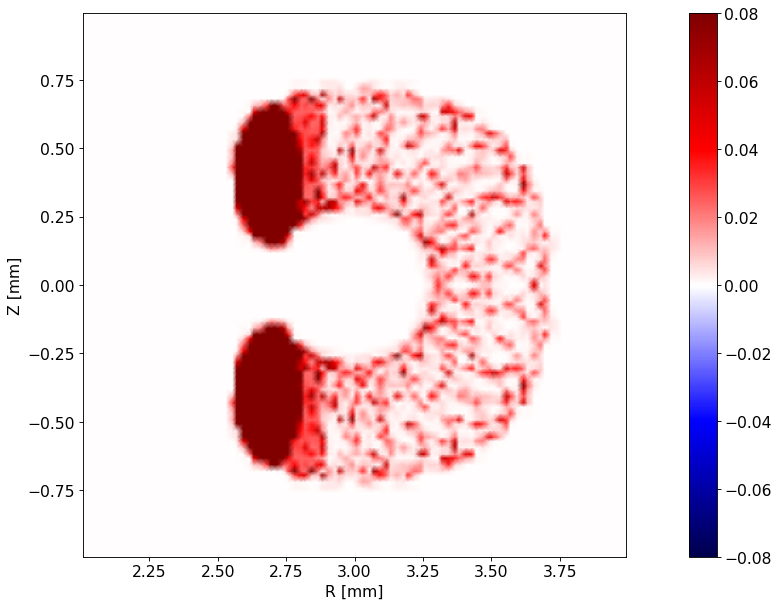

Running simulation fc16ef...c64e08.nc
ThreeDimensional/calibrate/fc16ef345339fb4fc87d544be10ab31ae5c64e08.nc
n: 3, Nx: 32, Nz: 20, mx: 10, method: linear-const


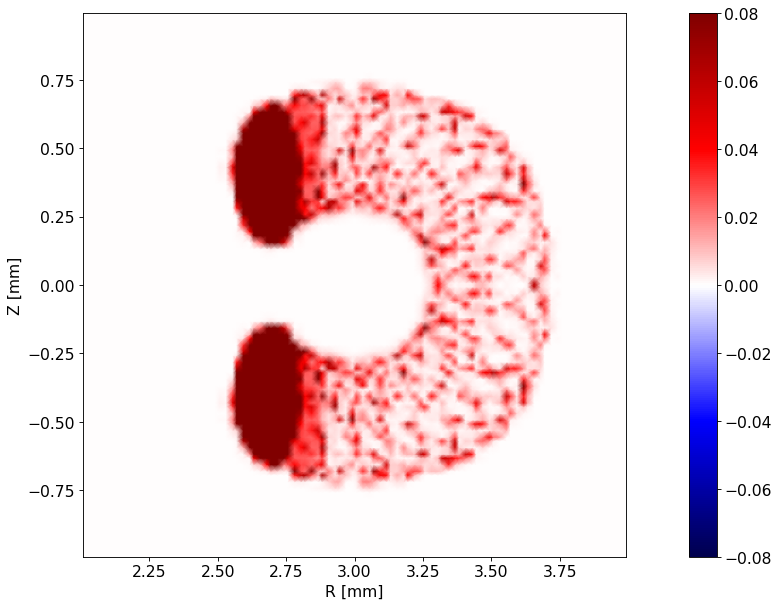

In [13]:
for method in ["linear-const"]:
    for mx in [1,10]:
        simulationfile = create_inputfile()
        simulationfile["flags"] = []
        simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
        simulationfile["init"]["density"]["ntilde"]["type"]="circle"
        simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
        simulationfile["output"]["maxout"] = 0
        simulationfile["advection"]["type"] = "centered"
        simulationfile["physical"]["nu_parallel"] = [0,1]

        simulationfile["FCI"]["refine"] = [mx,mx]
        simulationfile["FCI"]["interpolation-method"] = method
        simulationfile["grid"]["n"] = 3
        simulationfile["grid"]["Nx"] = 32
        simulationfile["grid"]["Ny"] = 32
        simulationfile["grid"]["Nz"] = 20
        plot(simulationfile)

We can also try to increase the perpendicular resolution. We see that the oscillations become smaller in size but do not vanish (likely because the step is sharp).

Running simulation 089bb2...eb3f80.nc
ThreeDimensional/calibrate/089bb24c57d0e428da3f60327d26f08959eb3f80.nc
n: 3, Nx: 60, Nz: 20, mx: 1, method: linear


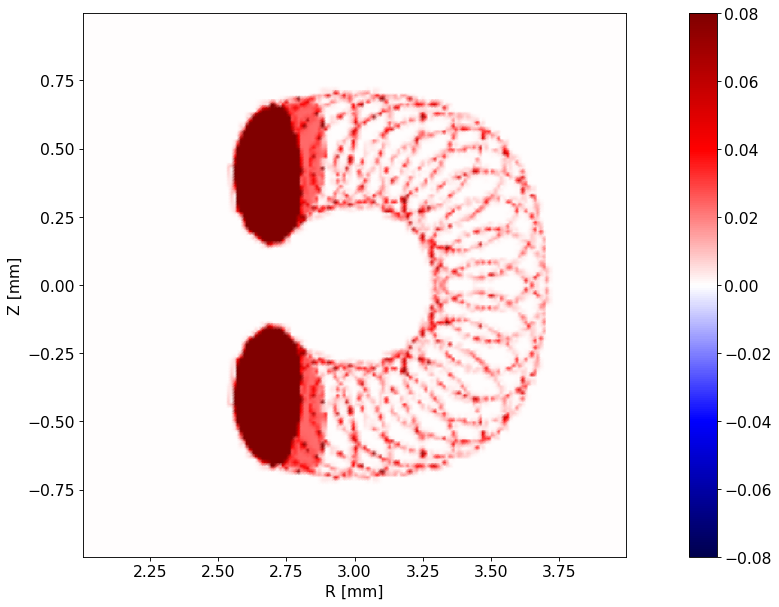

In [39]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
simulationfile["init"]["density"]["ntilde"]["type"]="circle"
simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
simulationfile["output"]["maxout"] = 0
simulationfile["advection"]["type"] = "centered"
simulationfile["physical"]["nu_parallel"] = [0,1]

simulationfile["FCI"]["refine"] = [1,1]
simulationfile["FCI"]["interpolation-method"] = "linear"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 60
simulationfile["grid"]["Ny"] = 60
simulationfile["grid"]["Nz"] = 20
plot(simulationfile)

We can also try to vary the number of polynomials in the dg interpolation method:
Clearly the higher the polynomial number the more oscillations appear.

Running simulation b255e0...9ee562.nc
ThreeDimensional/calibrate/b255e003b7406da9026f44a02a4e03d7619ee562.nc
n: 2, Nx: 50, Nz: 20, mx: 5, method: dg


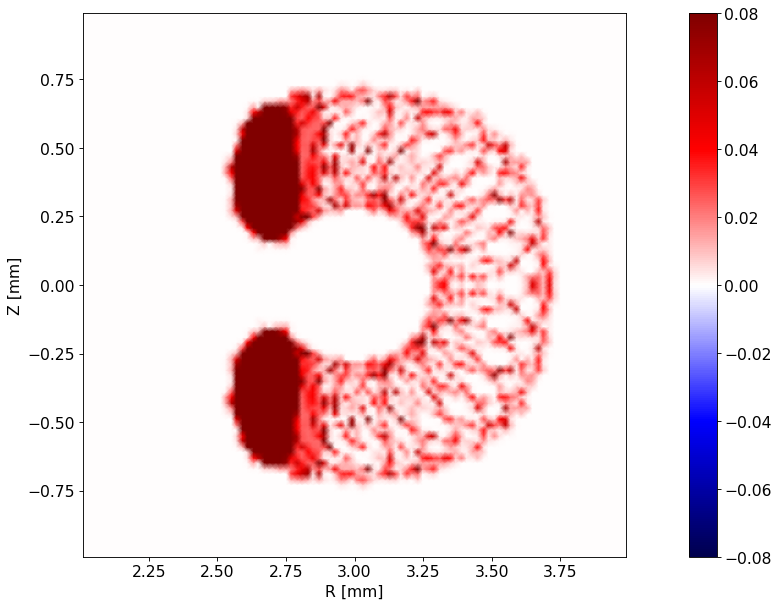

Running simulation 52f764...8ea8ad.nc
ThreeDimensional/calibrate/52f764e38ea03c994383851a4fc489cced8ea8ad.nc
n: 5, Nx: 20, Nz: 20, mx: 5, method: dg


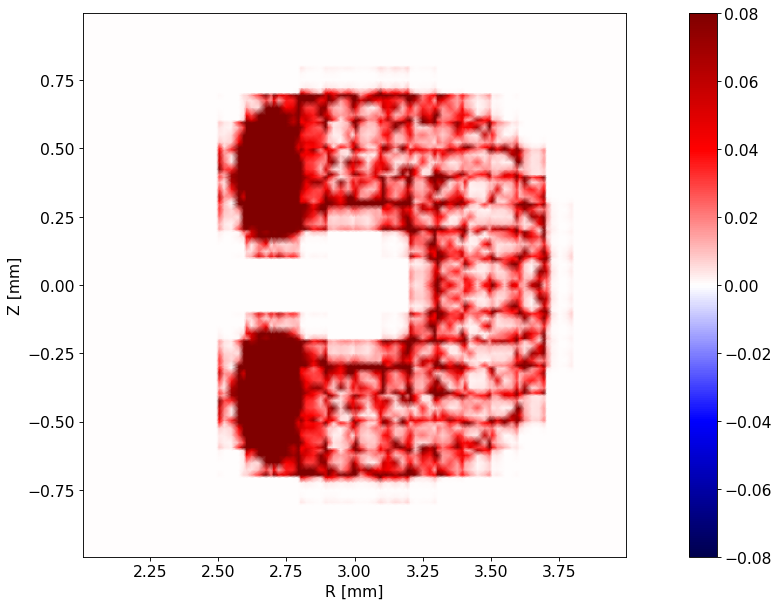

In [40]:
for n in [2,5] :
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
    simulationfile["init"]["density"]["ntilde"]["type"]="circle"
    simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
    simulationfile["output"]["maxout"] = 0
    simulationfile["advection"]["type"] = "centered"
    simulationfile["physical"]["nu_parallel"] = [0,1]

    simulationfile["FCI"]["refine"] = [5,5]
    simulationfile["FCI"]["interpolation-method"] = "dg"
    simulationfile["grid"]["n"] = n
    simulationfile["grid"]["Nx"] = 20
    simulationfile["grid"]["Ny"] = 20
    if n == 2 :
        simulationfile["grid"]["Nx"] = 50
        simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = 20
    plot(simulationfile)

In [5]:
# Define a plotting routine for the conservation equations
def plot_conservation( simfile, diagfile, plotfile, index):
    plt.rcParams.update({'font.size': 14})
    frows = 4
    fcols = 2
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1.25*6,frows*1.25*4),dpi= 80, facecolor='w', edgecolor='k')
    
    dset = Dataset( diagfile, 'r', format="NETCDF4")
    simset = Dataset( simfile, 'r', format="NETCDF4")
    plotset = Dataset( plotfile, 'r', format="NETCDF4")
    pp = json.loads(dset.inputfile)
    x = dset["x"][:]
    y = dset["y"][:]
    xc,yc = np.meshgrid( x, y)
    # 3d plot section
    xf = plotset["xf"][:]
    yf = plotset["yf"][:]
    zf = plotset["zf"][:]
    xfc2d = np.kron( np.ones(np.shape(zf)),xf).reshape( (np.size(zf), np.size(xf)))
    zfc2d = np.kron( zf, np.ones(np.shape(xf))).reshape( (np.size(zf), np.size(xf)))
    sectionY = pp["grid"]["Ny"]*pp["grid"]["n"]/2
    middleX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.5)/2 
    rightX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.71)/2
    ##
    time = dset['time'][:]
    timett = np.append( 2*time[0] -time[1]-2,time) # extrapolate
    deltat = np.diff(timett) # deltat_i = t[i] - t_[i-1]
    rho = dset['rho'][:]
    rho_t = dset['rho_t'][:]
    area = dset['psi_area'][:]
    volume = dset['psi_vol'][:]
    print( f"file : {simfile}")
    print( f"scheme = {pp['advection']['type']}", end=" ")
    print( f"limiter = {pp['advection']['slope-limiter']}", end=" ")
    print(f"time = {time[index]:5.2f}")
    gg = pp["grid"]
    fci = pp["FCI"]
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}", end='')
    print( f", nsteps: {simset['nsteps'][index]}, nfailed: {simset['failed'][index]}")
    
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    # Mass conservation
    print( f"Total mass conservation : {dset['ions_ifs_lcfs'][len(time)-1] - dset['ions_ifs_lcfs'][0]}")
    mass =dset['ions_fsa'][:,:]
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = dset['sni_tt_fsa'][:,:]/deltat[:,None]
    deltamass-=source

    
    divjvne=dset['divjnipar_tt_fsa'][:,:]/deltat[:,None]
    rhs =  divjvne
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:,:], axis=0)
    average_std =  np.std( diff[1:,:], axis=0)
    rr = 0
    cc = 1
    ax[rr][cc].plot( rho_t, average_diff, ls = '-', color='r', lw = 4)
    ax[rr][cc].fill_between( rho_t, average_diff-average_std, 
                      average_diff+average_std, color='r', alpha=0.2)
#     handles, labels = plt.gca().get_legend_handles_labels()
    ax[rr][cc].set_xlabel(r"$\rho_t$")
    ax[rr][cc].set_xlim([0.,1])
#     plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
    rr = 0
    cc = 0
    lower = 0.15
    upper = 0.225
    vo = simset['ions_2d'][index,:,:]
    im = ax[rr][cc].pcolormesh(xc,yc,vo, vmin=lower, vmax=upper, shading='gouraud', cmap='jet' )
    ax[rr][cc].axis('scaled')
    
#     vo = plotset['ionsFF'][index,:,sectionY,:]
#     im = ax[rr][cc].pcolormesh(xfc2d,zfc2d,vo,vmin=lower,vmax=upper, shading='gouraud', cmap='gist_ncar_r' )

    ax[rr][cc].set_title("Mass")
    fig.colorbar( im , ax=ax[rr][cc])
#     ax[rr][cc].plot( rho_t, mass[index,:], ls = '-', color='r', lw = 4, label='mass')
#     ax[rr][cc].set_xlabel(r"$\rho_t$")
#     ax[rr][cc].legend()
    
    # Momentum conservation
    mom_con = dset['niui_ifs_lcfs'][len(time)-1] - dset['niui_ifs_lcfs'][0] \
     - dset['sparmirrori_tt_ifs_lcfs'][len(time)-1]
    print( f"Total momentum conservation :{mom_con}")
    momentum = dset['niui_fsa'][:,:] 
    momentumtt=np.append(np.zeros((1,len(rho))),momentum, axis=0)
    deltamomentum = np.diff(momentumtt,axis=0)/deltat[:,None]
    source = dset.variables['sei_tt_fsa'][:,:]/deltat[:,None]
    deltamomentum-=source
    
    divjpari=dset['divjpari_tt_fsa'][:,:]/deltat[:,None]
    force = dset['sparmirrori_tt_fsa'][:,:]/deltat[:,None]
    diff_para = dset["lparpar_tt_fsa"][:,:]/deltat[:,None]
    rhs =  - force - diff_para  + divjpari
    diff = (deltamomentum + rhs)/2
   
    average_diff = np.mean( diff[1:,:], axis=0)
    average_std =  np.std( diff[1:,:], axis=0)
    rr = 1
    cc = 1
    ax[rr][cc].plot( rho_t, average_diff, ls = '-', color='r', lw = 4)
    ax[rr][cc].fill_between( rho_t, average_diff-average_std, 
                      average_diff+average_std, color='r', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    ax[rr][cc].set_xlabel(r"$\rho_t$")
    ax[rr][cc].set_xlim([0,1])
#     plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
    rr = 1
    cc = 0    
    lower = -0.05
    upper = 0.05
    vo = simset['niui_2d'][index,:,:]
    im = ax[rr][cc].pcolormesh(xc,yc,vo, vmin=lower, vmax=upper, shading='gouraud', cmap='seismic' )
    ax[rr][cc].axis('scaled')
#     vo = plotset['UiFF'][index,:,sectionY,:]
#     im = ax[rr][cc].pcolormesh(xfc2d,zfc2d,vo,vmin=lower,vmax=upper, shading='gouraud', cmap='seismic' )

    ax[rr][cc].set_title("Momentum")
    fig.colorbar( im , ax=ax[rr][cc])
#     ax[rr][cc].plot( rho_t, momentum[index, :], ls = '-', color='r', lw = 4, label='momentum')
#     ax[rr][cc].set_xlabel(r"$\rho_t$")
#     ax[rr][cc].legend()
        
    # Energy conservation
    energy1d = dset["nilnni_ifs_lcfs"][:] + dset["niui2_ifs_lcfs"][:]
    print( f"Total energy conservation : {energy1d[len(time)-1] - energy1d[0]}")
    energy = dset['nilnni_fsa'][:,:] + dset['niui2_fsa'][:,:]
    energytt=np.append(np.zeros((1,len(rho))),energy, axis=0)
    deltaenergy = np.diff(energytt,axis=0)/deltat[:,None]
    source = dset.variables['sei_tt_fsa'][:,:]/deltat[:,None]
    deltaenergy-=source
    
    divjv=dset['divjeipar_tt_fsa'][:,:]/deltat[:,None]
    diff_para = dset["leiparallel_tt_fsa"][:,:]/deltat[:,None]
    rhs = - diff_para +divjv 
    diff = (deltaenergy + rhs)/2
   
    average_diff = np.mean( diff[1:,:], axis=0)
    average_std =  np.std( diff[1:,:], axis=0)
    rr = 2
    cc = 1
    ax[rr][cc].plot( rho_t, average_diff, ls = '-', color='r', lw = 4)
    ax[rr][cc].fill_between( rho_t, average_diff-average_std, 
                      average_diff+average_std, color='r', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    ax[rr][cc].set_xlabel(r"$\rho_t$")
#     plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
#                    fontsize='medium',framealpha=0.5)
    rr = 2
    cc = 0
    lower = -0.35
    upper = -0.15
    vo = simset['nilnni_2d'][index,:,:] + simset["niui2_2d"][index,:,:]
    im = ax[rr][cc].pcolormesh(xc,yc,vo, vmin=lower, vmax=upper, shading='gouraud', cmap='plasma' )
    ax[rr][cc].axis('scaled')
    ax[rr][cc].set_title("Energy")
    fig.colorbar(im, ax=ax[rr][cc])
#     ax[rr][cc].plot( rho_t, energy[index, 0:167], ls = '-', color='r', lw = 4, label='energy')
#     ax[rr][cc].set_xlabel(r"$\rho_t$") 
#     ax[rr][cc].legend()
    
    rr = 3
    cc = 0
    ax[rr][cc].plot( zf, plotset["ionsFF"][index, :, sectionY, middleX], ls = '-', color='r', lw = 4)
    rr = 3
    cc = 1
    ax[rr][cc].plot( zf, plotset["ionsFF"][index, :, sectionY, rightX], ls = '-', color='r', lw = 4)
    dset.close()
    simset.close()
    plotset.close()
    
    plt.show()
    # plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")
    # plt.xlim(60,130)
    # plt.ylim(-0.05,0.05)
    # plt.ylim(0,30000)


In [6]:
def create_default_config():
    configfile = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fsa" : "toroidal-average",
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 1
    }
    return configfile

config = create_default_config()
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [7]:
simulator = simplesim.Manager( executable="./feltor.sh", directory="ThreeDimensional/data", filetype="nc")
diagnoser = simplesim.Manager( executable="./feltordiag.sh", directory="ThreeDimensional/diag", filetype="nc")
interpolator = simplesim.Manager( executable ="./feltorplot.sh",
                                  directory="ThreeDimensional/plot", filetype = "nc")
# help (simplesim)

### Navier-Stokes equation in 3d
First, let us try to simulate the centered scheme and the velocity-staggered scheme with the linear interpolation scheme. We see that the centered scheme, as expected, produces oscillations (that without parallel diffusion become unstable immediately).

Running simulation f55f29...93dccd.nc
Running simulation f55f29...93dccd.nc
Running simulation f55f29...93dccd.nc
file : ThreeDimensional/data/f55f291b9661ff1a9914ead9c6dbd516b093dccd.nc
scheme = centered limiter = none time = 10.00
n: 3, Nx: 32, Nz: 20, mx: 5, method: dg, nsteps: 323.0, nfailed: 0.0
Total mass conservation : -0.0018000378822016216
Total momentum conservation : -0.010684279849367385
Total energy conservation : 0.016784559174499947


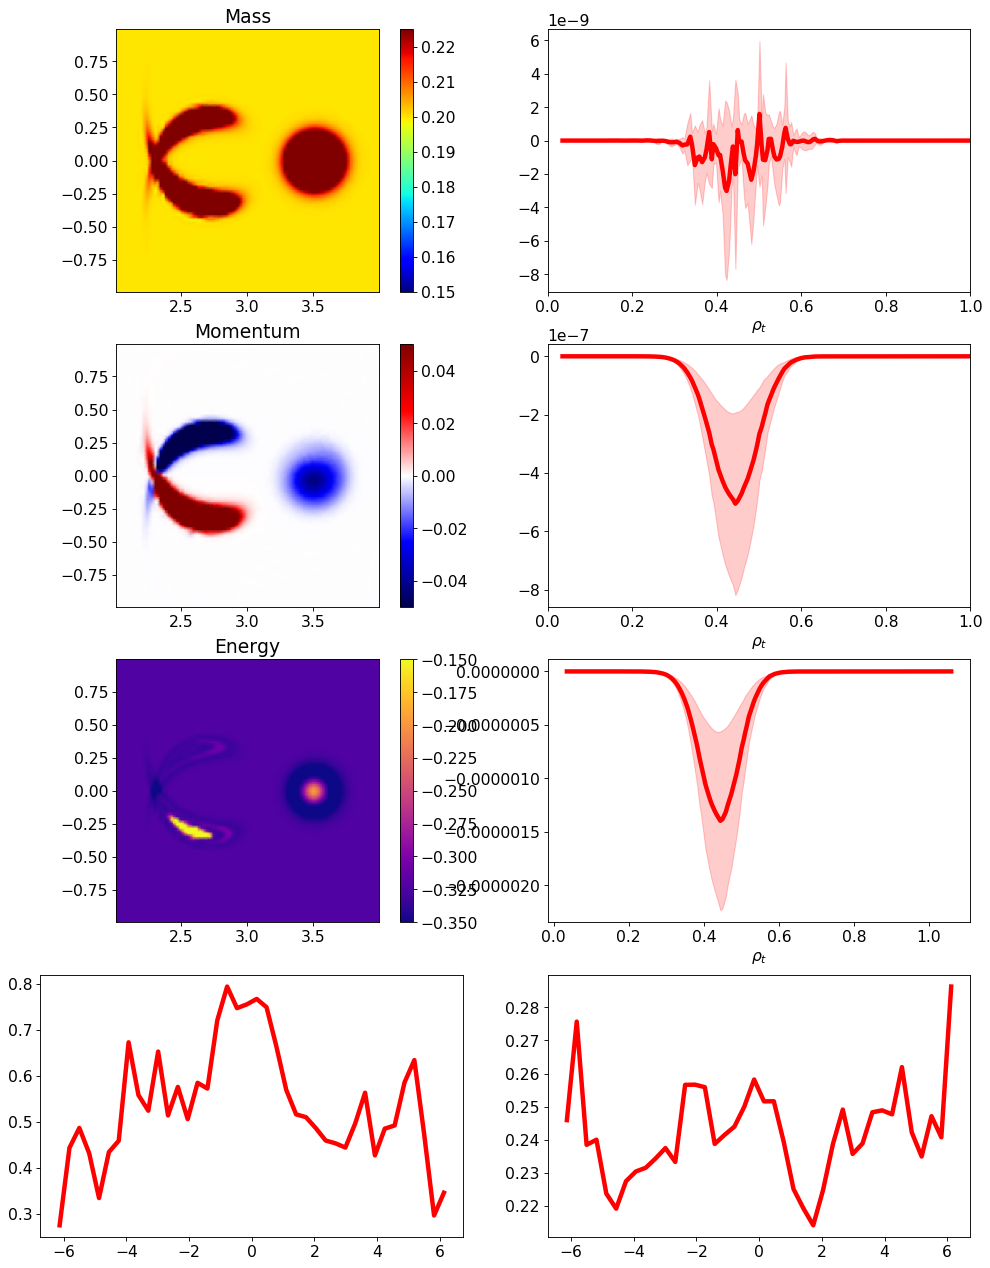

Running simulation d903f5...d9034e.nc
Running simulation d903f5...d9034e.nc
Running simulation d903f5...d9034e.nc
file : ThreeDimensional/data/d903f5d891304a77e251b73b3be71e6e84d9034e.nc
scheme = velocity-staggered limiter = none time = 10.00
n: 3, Nx: 32, Nz: 20, mx: 5, method: dg, nsteps: 356.0, nfailed: 0.0
Total mass conservation : -2.1339388236896184e-05
Total momentum conservation : -0.023532513547924346
Total energy conservation : -0.0361409667428525


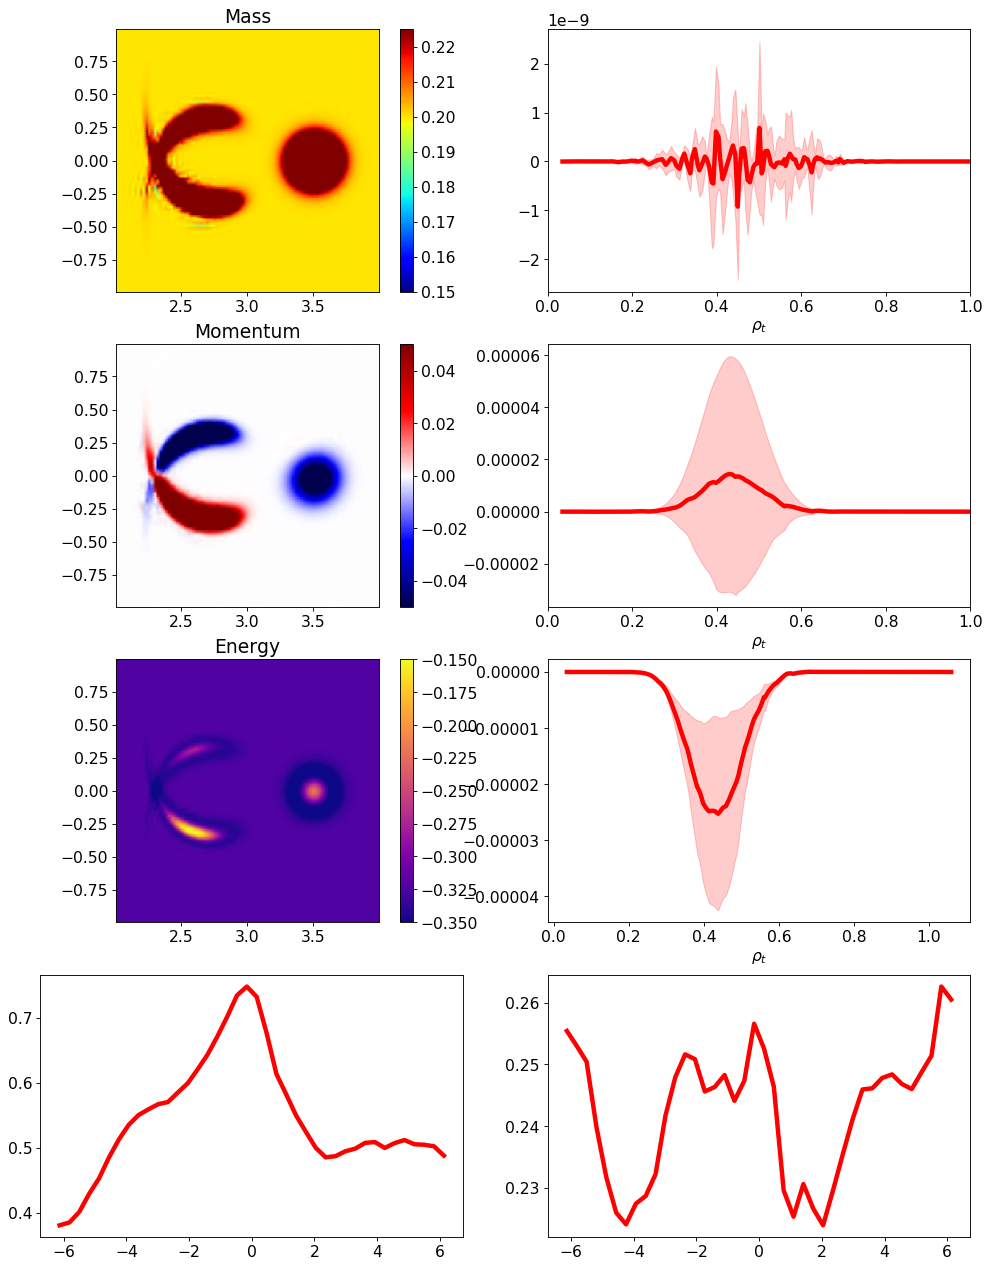

Running simulation 2ffa8e...637392.nc
Running simulation 2ffa8e...637392.nc
Running simulation 2ffa8e...637392.nc
file : ThreeDimensional/data/2ffa8e22982d2ea4bf404b1a077f8cfecb637392.nc
scheme = velocity-staggered-fieldaligned limiter = none time = 10.00
n: 3, Nx: 32, Nz: 20, mx: 5, method: dg, nsteps: 356.0, nfailed: 0.0
Total mass conservation : -0.00038079852803107883
Total momentum conservation : -0.02379650515161555
Total energy conservation : -0.0364824187458197


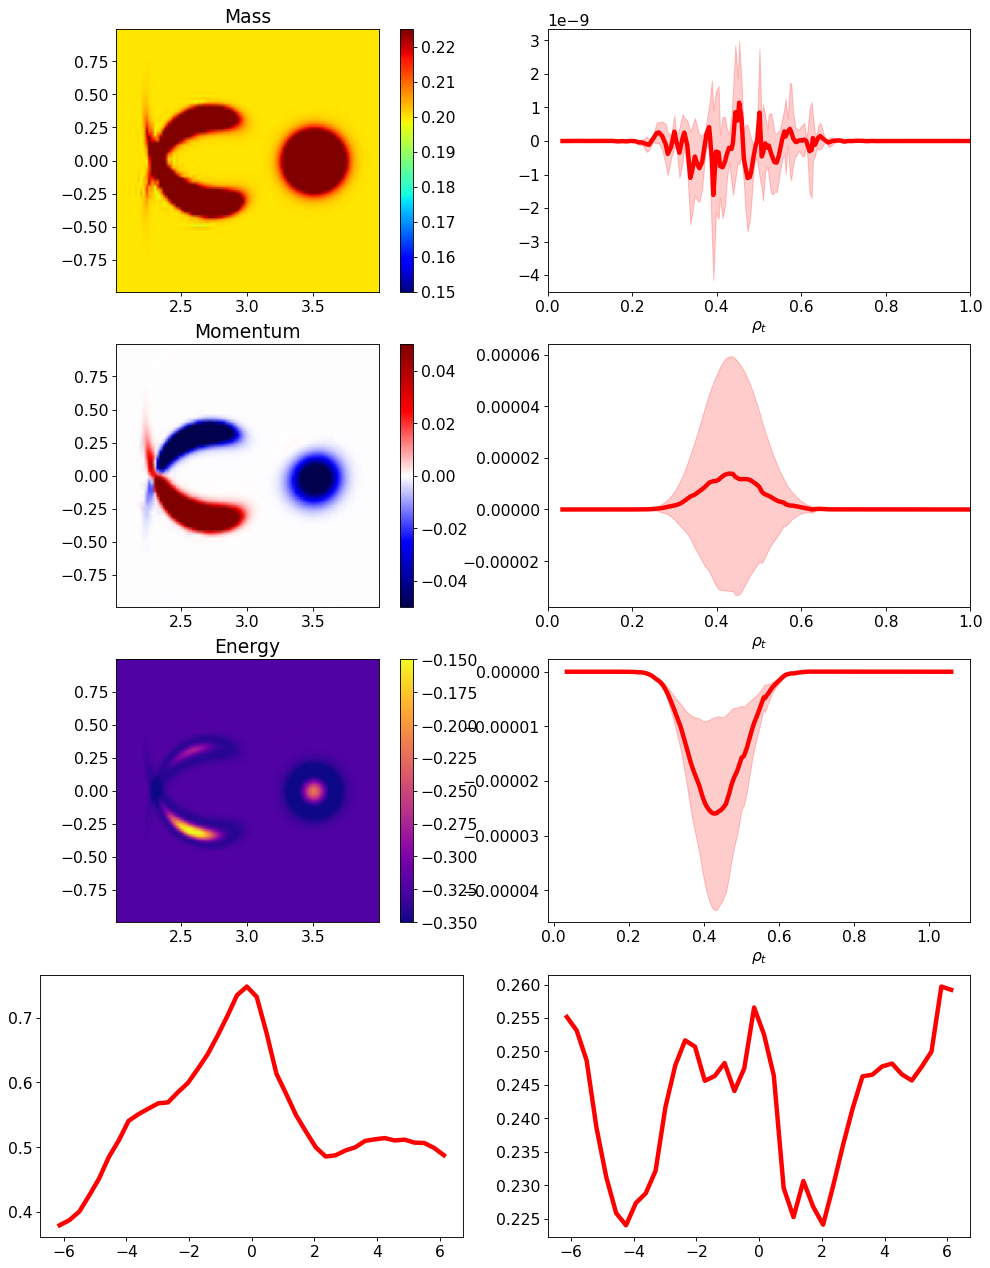

In [8]:
for scheme in ["centered",  "velocity-staggered", "velocity-staggered-fieldaligned"]: #"centered-forward",
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["advection"]["type"] = scheme
    simulationfile["physical"]["nu_parallel"] = [0,0]
    simulationfile["FCI"]["refine"] = [5,5]

    simulationfile["grid"]["Nx"] = 32
    simulationfile["grid"]["Ny"] = 32
    simulationfile["grid"]["Nz"] = 20

    simulationfile["FCI"]["interpolation-method"] = "dg"
    simulationfile["advection"]["slope-limiter"] = "none"
    simulationfile["regularization"]["alpha0"]= 3
    simulationfile["regularization"]["iter"]= 1
    if ( "implicit" in scheme) :
        simulationfile["timestepper"]["type"] = "adaptive-imex"
        simulationfile["timestepper"]["tableau"] = "ARK-4-2-3"
    simfile = simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    plotfile = interpolator.create( simulationfile)
    plot_conservation(simfile, diagfile, plotfile,1)
# rep = simplesim.Repeater( "./feltor.sh", "temp.json", "temp.nc")
# rep.run ( simulationfile)

Running simulation a88190...e5f0cb.nc
Running simulation a88190...e5f0cb.nc
Running simulation a88190...e5f0cb.nc
file : ThreeDimensional/data/a8819030f684e73ddd9192fa8f5f8e3641e5f0cb.nc
scheme = staggered-fieldaligned limiter = none time = 10.00
n: 3, Nx: 32, Nz: 20, mx: 5, method: linear-const, nsteps: 329.0, nfailed: 0.0
Total mass conservation : -0.0004474964203566856
Total momentum conservation : -0.024659746901396457
Total energy conservation : -0.03975059315559548


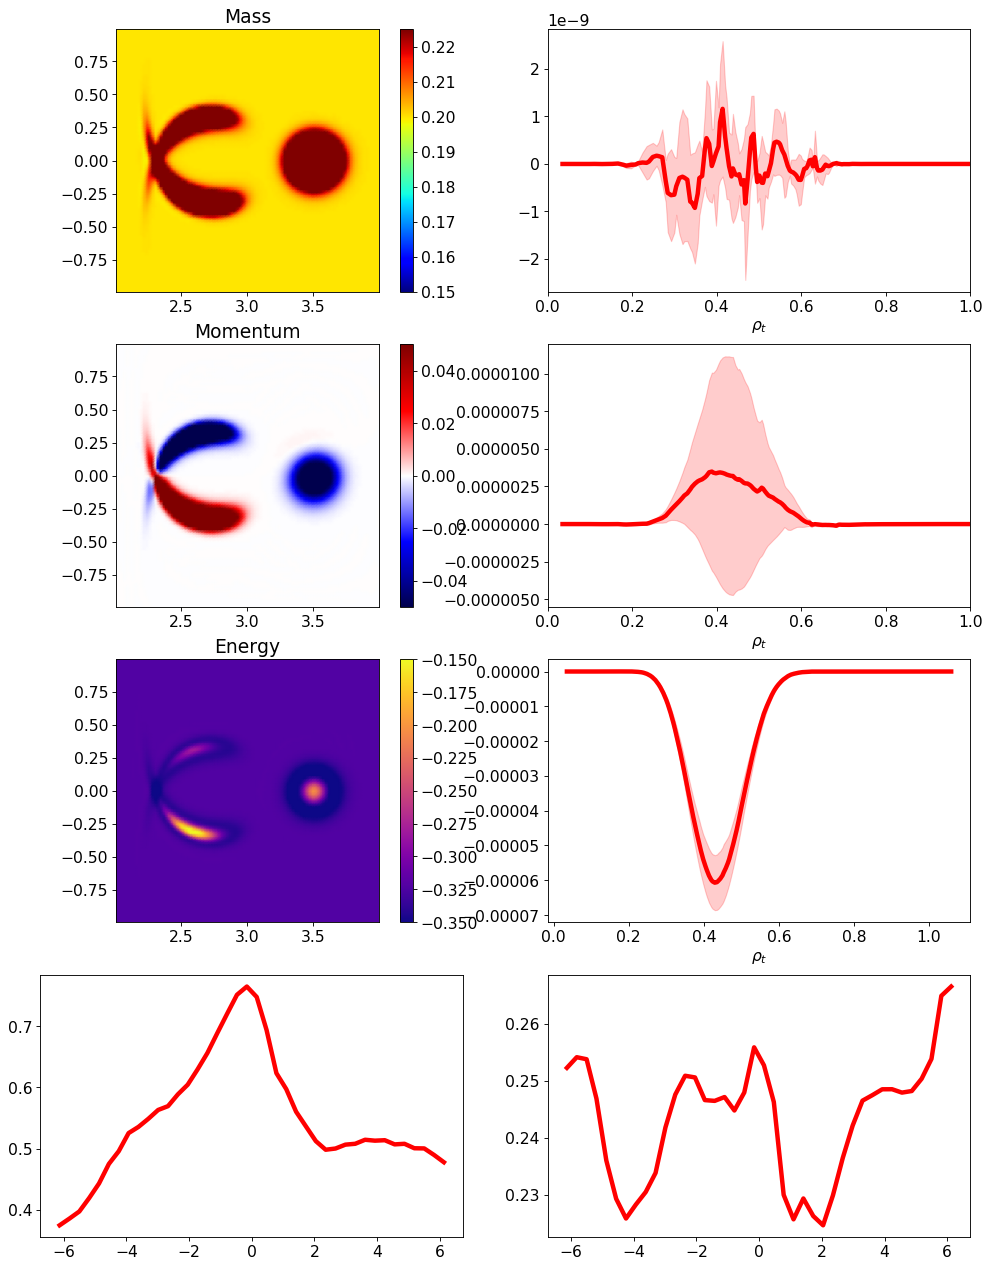

Running simulation 86dd3f...0c1ae0.nc
Running simulation 86dd3f...0c1ae0.nc
Running simulation 86dd3f...0c1ae0.nc
file : ThreeDimensional/data/86dd3f752f742c6dd2a24814be63851a280c1ae0.nc
scheme = staggered-fieldaligned-implicit limiter = none time = 10.00
n: 3, Nx: 32, Nz: 20, mx: 5, method: linear-const, nsteps: 430.0, nfailed: 0.0
Total mass conservation : -0.00044751573477164186
Total momentum conservation : -0.024659864222910926
Total energy conservation : -0.03974770899846902


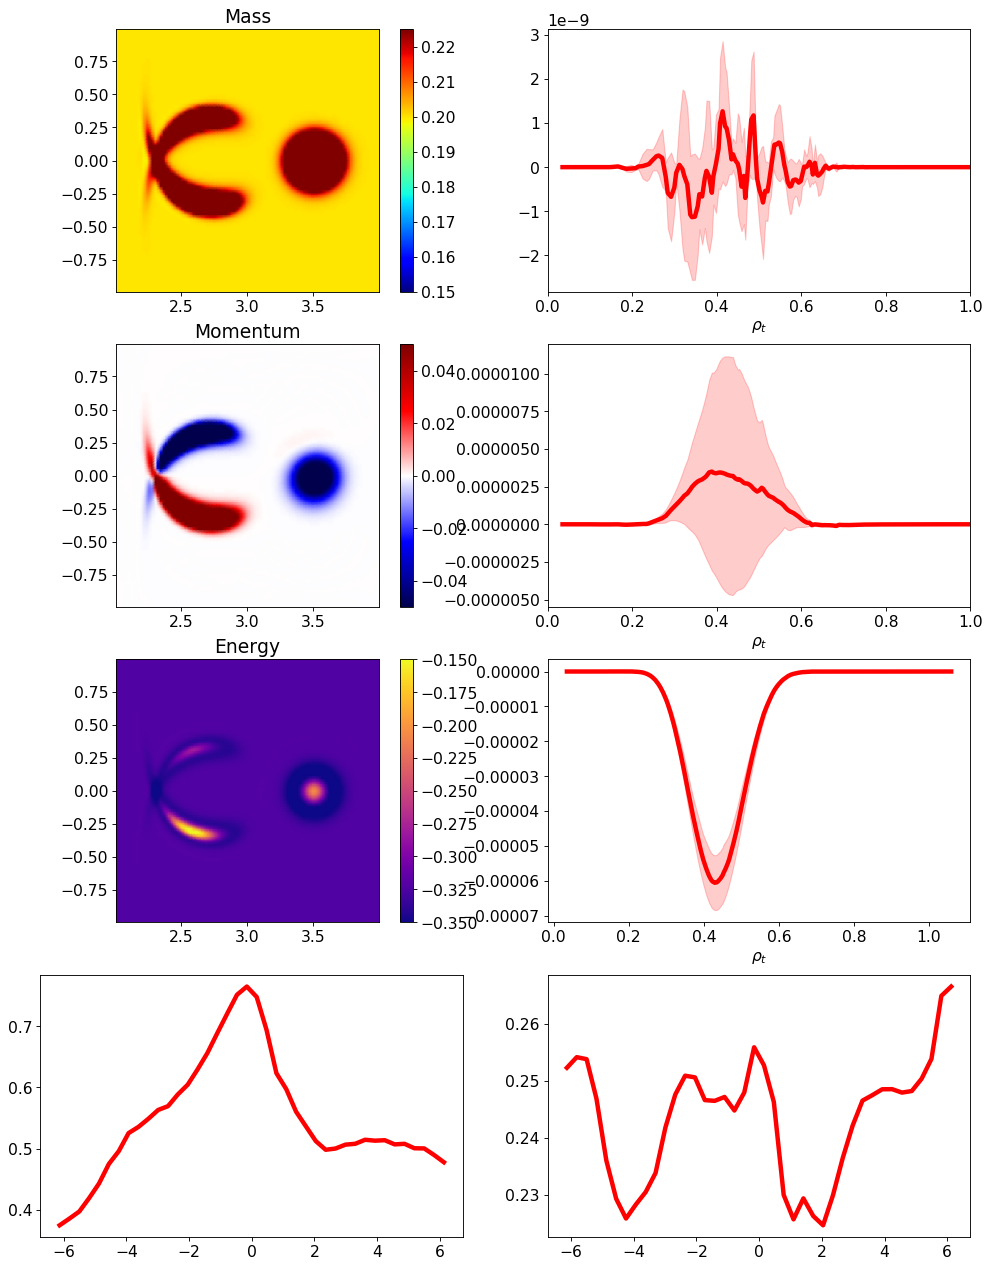

In [9]:
for scheme in ["staggered-fieldaligned", "staggered-fieldaligned-implicit"]: #"centered-forward",
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["advection"]["type"] = scheme
    simulationfile["physical"]["nu_parallel"] = [0,0]
    simulationfile["FCI"]["refine"] = [5,5]

    simulationfile["grid"]["Nx"] = 32
    simulationfile["grid"]["Ny"] = 32
    simulationfile["grid"]["Nz"] = 20

    simulationfile["FCI"]["interpolation-method"] = "linear-const"
    simulationfile["advection"]["slope-limiter"] = "none"
    if ( "implicit" in scheme) :
        simulationfile["timestepper"]["type"] = "adaptive-imex"
        simulationfile["timestepper"]["tableau"] = "ARK-4-2-3"
        simulationfile["timestepper"]["solver"] = {"eps_time" : 1e-10, "type" : "lgmres"}
    simfile = simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    plotfile = interpolator.create( simulationfile)
    plot_conservation(simfile, diagfile, plotfile,5)
# rep = simplesim.Repeater( "./feltor.sh", "temp.json", "temp.nc")
# rep.run ( simulationfile)

Our next test reveals a problem of the current scheme. The oscillations inherent in the parallel derivative manifest strongly after a long time. The densities can become negative. We also note here that with the "dg" interpolation scheme the velocity-staggered scheme becomes unstable very quickly. After a sufficient time there is a risk that also this scheme becomes unstable.
This problem also does not vanish by increasing the resolution or the refinement of the FCI scheme.

In [12]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered-fieldaligned"
simulationfile["physical"]["nu_parallel"] = [0,0.]
simulationfile["FCI"]["refine"] = [5,5]
simulationfile["FCI"]["interpolation-method"] = "linear-const"
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "minmod"
simulationfile["timestepper"]["Tend"] = 20
simulationfile["regularization"]["nu_perp_n"] = 0
simulationfile["regularization"]["nu_perp_u"] = 0
simfile =  simulator.recreate( simulationfile)
diagfile = diagnoser.recreate( simulationfile)
plotfile = interpolator.recreate( simulationfile)
plot_conservation(simfile, diagfile, plotfile,5)

Running simulation 46dc10...669dd2.nc


KeyboardInterrupt: 

Let us therefore add a perpendicular diffusion operator to the equations.
Our first attempt uses the "centered" direction, which however produces oscillations. These oscillations increase by increasing the order of the polynomials and decrease (but do not vanish entirely) by increasing the perpendicular resolution. 
The parallel resolution seems not to matter for that phenomenon

Existing simulation 4b8635...aeb15e.nc
Existing simulation 4b8635...aeb15e.nc
Existing simulation 4b8635...aeb15e.nc
file : ThreeDimensional/data/4b8635180b3124f2cec6464e8ec9917addaeb15e.nc
scheme = velocity-staggered-fieldaligned limiter = none time = 10.00
n: 3, Nx: 32, Nz: 20, mx: 5, method: linear-const, nsteps: 323.0, nfailed: 0.0
Total mass conservation : -2.7372510587042598e-05
Total momentum conservation : -0.02142626760771626
Total energy conservation : -0.06096267409727929


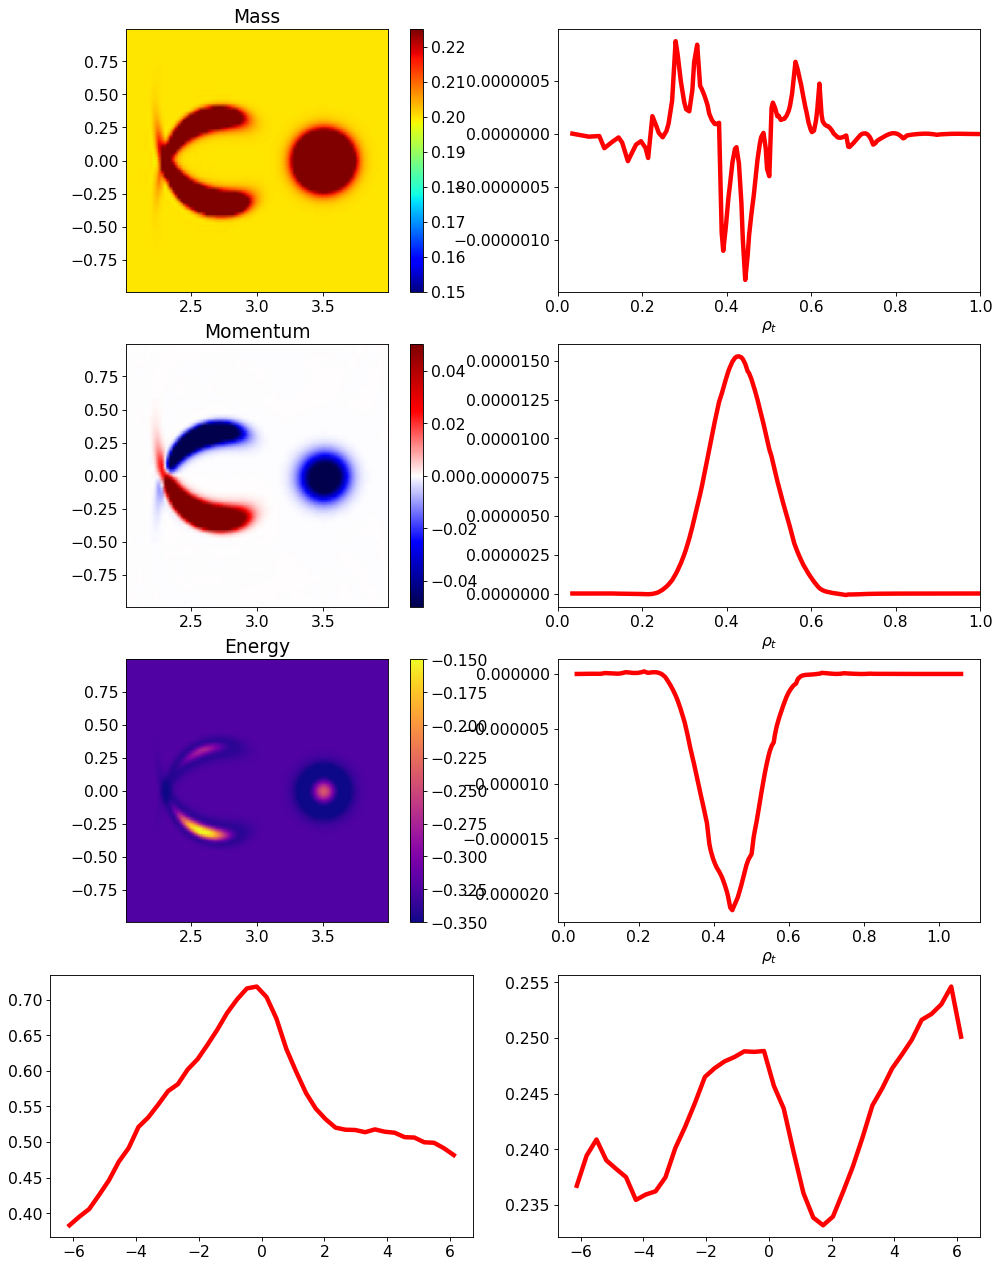

In [11]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered-fieldaligned"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["FCI"]["refine"] = [5,5]
simulationfile["FCI"]["interpolation-method"] = "linear-const"
simulationfile["grid"]["n"] = 3 # order 6 makes more oscis
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 10
simulationfile["regularization"]["order"] = 2
simulationfile["regularization"]["direction"] = "centered"
simulationfile["regularization"]["nu_perp_n"] = 1e-9
simulationfile["regularization"]["nu_perp_u"] = 1e-9
simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
plot_conservation(simfile, diagfile, plotfile,1)

Only if we change the direction to "forward" do the oscillations vanish:

In [ ]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered-fieldaligned"
simulationfile["physical"]["nu_parallel"] = [0,0.]
simulationfile["FCI"]["refine"] = [5,5]
simulationfile["FCI"]["interpolation-method"] = "linear-const"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 10
simulationfile["regularization"]["order"] = 2
simulationfile["regularization"]["direction"] = "forward"
simulationfile["regularization"]["nu_perp_n"] = 1e-9
simulationfile["regularization"]["nu_perp_u"] = 1e-9
simfile =  simulator.recreate( simulationfile)
diagfile = diagnoser.recreate( simulationfile)
plotfile = interpolator.recreate( simulationfile)
plot_conservation(simfile, diagfile, plotfile,5)

In [ ]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered-fieldaligned"
simulationfile["physical"]["nu_parallel"] = [0,0.]
simulationfile["FCI"]["refine"] = [10,10]
simulationfile["FCI"]["interpolation-method"] = "linear-const"
simulationfile["grid"]["n"] = 1
simulationfile["grid"]["Nx"] = 96
simulationfile["grid"]["Ny"] = 96
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 20
simulationfile["regularization"]["type"] = "none"
simulationfile["regularization"]["alpha"] = 1
simulationfile["regularization"]["iter"] = 1
simulationfile["regularization"]["order"] = 2
simulationfile["regularization"]["direction"] = "forward"
simulationfile["regularization"]["nu_perp_n"] = 0
simulationfile["regularization"]["nu_perp_u"] = 0
simulationfile["regularization"]["jfactor"] = 1
simulationfile["regularization"]["alpha0"] = 0
simulationfile["regularization"]["iter"] = 1
simfile =  simulator.recreate( simulationfile)
diagfile = diagnoser.recreate( simulationfile)
plotfile = interpolator.recreate( simulationfile)
plot_conservation(simfile, diagfile, plotfile,5)

We are thus ready to simulate the double-step problem for a long time and high resolution:

Existing simulation 9b3527...9f1f5b.nc
Existing simulation 9b3527...9f1f5b.nc
Existing simulation 9b3527...9f1f5b.nc
file : ThreeDimensional/data/9b35273d045f1c6b63fe78d0ddf55a95e69f1f5b.nc
scheme = velocity-staggered-fieldaligned limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 5, method: linear-linear, nsteps: 465.0, nfailed: 4.0
Total mass conservation : -0.004767576450975142
Total momentum conservation :0.002047861764248313
Total energy conservation : -0.15737100428038175


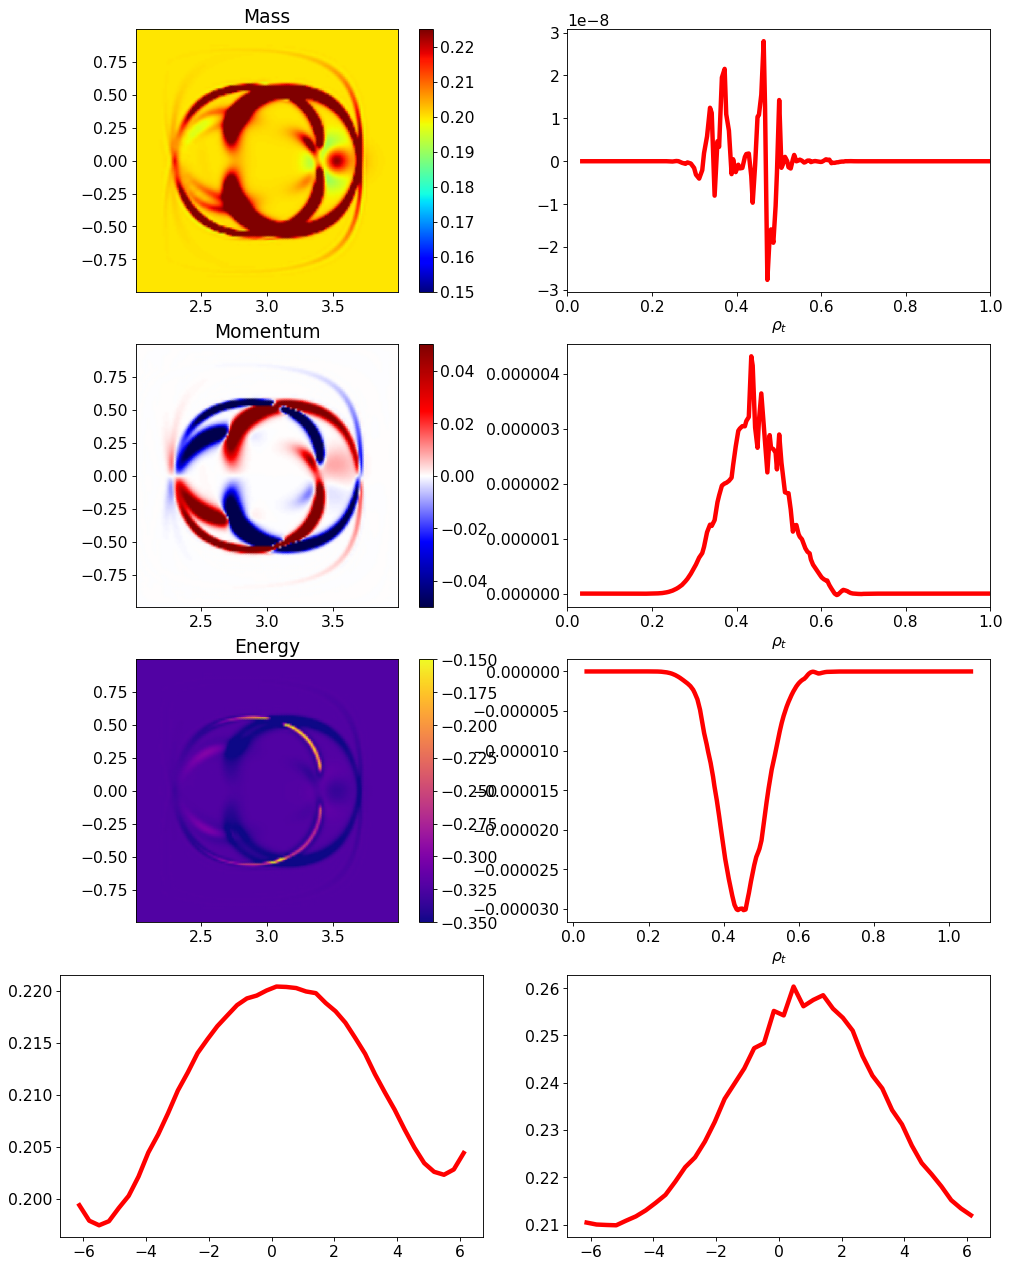

In [16]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered-fieldaligned"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["FCI"]["refine"] = [5,5]
simulationfile["FCI"]["interpolation-method"] = "linear-linear"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simulationfile["regularization"]["type"] = "none"
simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
plot_conservation(simfile, diagfile, plotfile,1)

Running simulation 6e8c79...fa3ad9.nc
Running simulation 6e8c79...fa3ad9.nc
Running simulation 6e8c79...fa3ad9.nc
file : ThreeDimensional/data/6e8c79be1bace277b82a5e373c1f950977fa3ad9.nc
scheme = staggered-fieldaligned limiter = none time = 40.00
n: 1, Nx: 150, Nz: 20, mx: 5, method: linear-equi-nearest, nsteps: 608.0, nfailed: 0.0
Total mass conservation : -0.06754646873420711
Total momentum conservation :-0.0012764949259061152
Total energy conservation : -0.4734972265191999


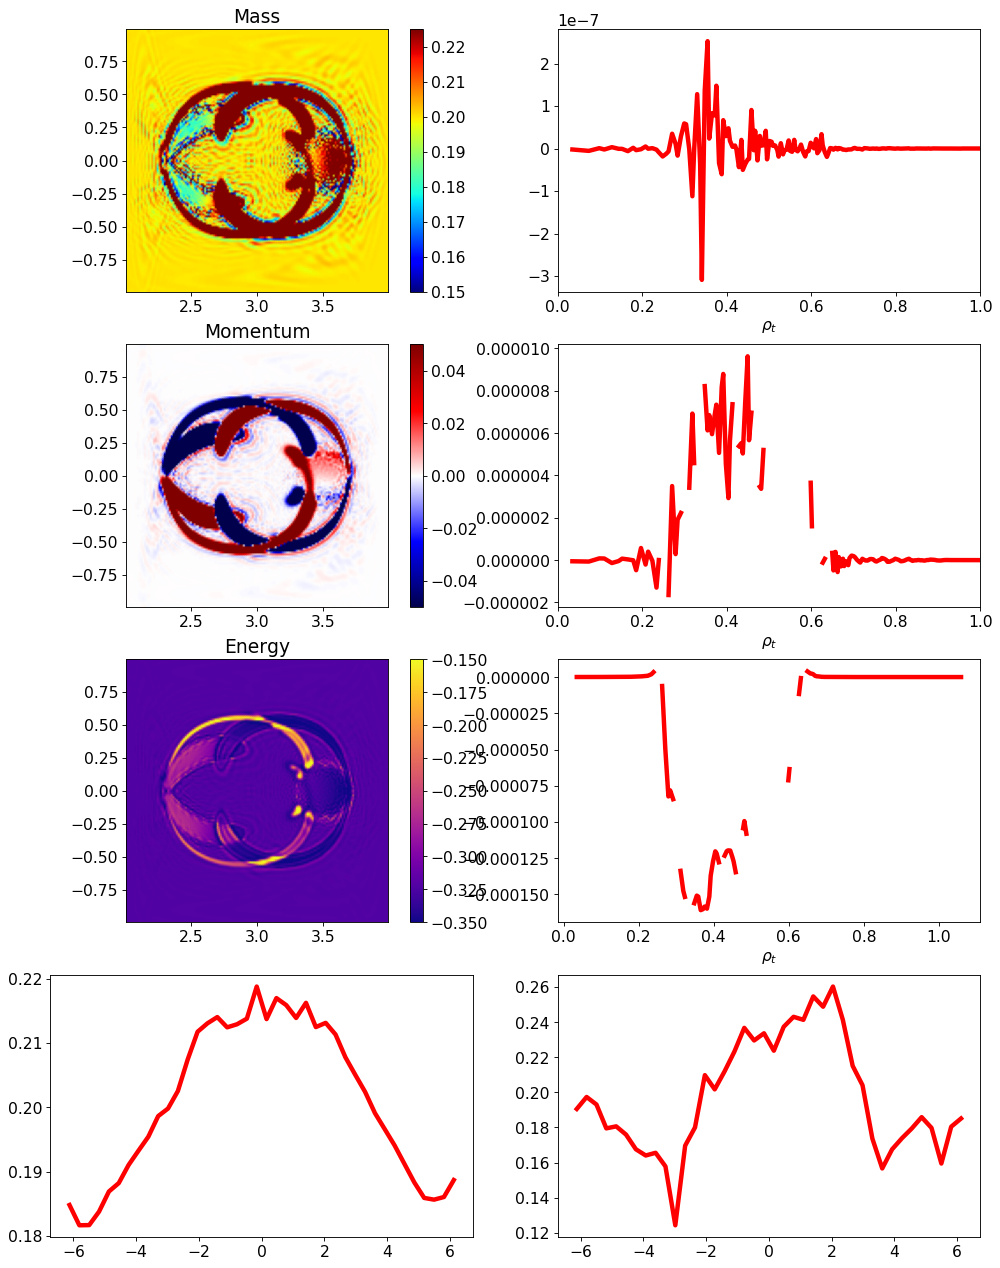

In [64]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered-fieldaligned"
simulationfile["physical"]["nu_parallel"] = [0,0.0]
simulationfile["FCI"]["refine"] = [5,5]
simulationfile["grid"]["n"] = 1
simulationfile["grid"]["Nx"] = 150
simulationfile["grid"]["Ny"] = 150
simulationfile["grid"]["Nz"] = 20
simulationfile["FCI"]["interpolation-method"] = "linear-equi-nearest"
simulationfile["init"]["density"]["ntilde"]["parallel"]="double-step"
simulationfile["init"]["density"]["ntilde"]["type"]="circle"
simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simulationfile["regularization"]["type"] = "none"
simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
plot_conservation(simfile, diagfile, plotfile,1)

In [20]:
def plot2d (f, save) :
    ncin = Dataset( simulator.select(f), 'r', format="NETCDF4")
    # time, xc, yc, vorticity, potential,
    # error(t), time_per_step(t), energy_1d(t), enstrophy_1d(t), vorticity_1d(t)
    max_idx = ncin.variables["time"].shape[0]-1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc,yc = np.meshgrid( x, y)
    vol = ncin["vol2d"][:,:]
    time = ncin["time"][:]
    max_idx = np.size( time)-1
    nsteps = ncin.variables["nsteps"][max_idx]

    fig,ax=plt.subplots(1,2,figsize=(2*8,8),dpi= 80, facecolor='w', edgecolor='k')
    
    lower = 0.15
    upper = 0.225

    lower = 0.1
    upper = 0.7
    im = ax[0].pcolormesh(xc,yc,ncin['ions_2d'][max_idx,:,:],
                          vmin=lower, vmax=upper,
                          shading='gouraud', cmap='jet' )
    ax[0].axis('scaled')
    ax[0].set_title("Mass")
    vo = ncin['ions_ta2d'][:,:,:]
    mass0 = np.sum( vo[0,:,:]*vol )
    mass1 = np.sum( vo[max_idx,:,:]*vol )
    vo = ncin['nilnni_ta2d'][:,:,:] + ncin["niui2_ta2d"][:,:,:]
    energy0 = np.sum( vo[0,:,:]*vol )
    energy1 = np.sum( vo[max_idx,:,:]*vol )
    textstr = '\n'.join((
    r'$%.d \times %.d \times %.d \times %.d $   $(n \times N_x \times N_z \times N_T )$' % (
        f["grid"]["n"], f["grid"]["Nx"], f["grid"]["Nz"],nsteps  ),
        '',
    'Relative error in conserved quantities:',
    r'$\varepsilon_M=%.2e$' % ((mass1-mass0)/mass0),
    r'$\varepsilon_E=%.2e$' % ((energy1-energy0)/energy0),
                '',
    'interpolation/projection : ' + f["FCI"]["interpolation-method"] ,
    'advection                : ' + f["advection"]["type"] ,
    'nu_parallel              : ' + (r" $%.1f$"%f["physical"]["nu_parallel"][1]
    ), 
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
    #ax[1].set_title( f["grid"]["n"])
    
#     fig.colorbar(im, ax=ax[0])
    ax[1].axis('off')
    if save :
        hashed = simulator.hashinput(f)
        plt.savefig( "pics/"+hashed+".png",bbox_inches='tight')
        plt.close()
    else :
        pass

In [18]:
for nu in [0, 0.2]:
    for p in {"linear", "cubic", "linear-nearest","linear-linear", "linear-equi-nearest",
              "cubic-nearest", "cubic-equi-nearest", "cubic-linear", "cubic-equi-linear"
             } :
        for m in {"","-fieldaligned"}:
            simulationfile = create_inputfile()
            simulationfile["flags"] = []
            simulationfile["FCI"]["interpolation-method"] = p
            simulationfile["FCI"]["refine"] = [5,5]
            
            if nu != 0:
                simulationfile["advection"]["type"] = "velocity-staggered"+m
            else:
                simulationfile["advection"]["type"] = "staggered"+m
            simulationfile["advection"]["slope-limiter"] = "none"
            
            simulationfile["physical"]["nu_parallel"] = [0,nu]
            simulationfile["grid"]["n"] = 3
            simulationfile["grid"]["Nx"] = 50
            simulationfile["grid"]["Ny"] = 50
            simulationfile["grid"]["Nz"] = 20
                
           
            simulationfile["timestepper"]["Tend"] = 40
            simulationfile["regularization"]["type"] = "none"
            
            simulationfile["init"]["density"]["ntilde"]["parallel"]="double-step"
            simulationfile["init"]["density"]["ntilde"]["type"]="circle"
            simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
            simfile = simulator.create(simulationfile, error="display")
                
        

Existing simulation aaa4d5...0c0571.nc
Running simulation eacbd3...0d4175.nc
Running simulation 9a3803...93eaa4.nc
Running simulation 811ac7...6dd408.nc
Running simulation c8c2f8...5e6655.nc
Running simulation 99bc42...f2f277.nc
Running simulation 7ca0c1...2679d5.nc
Running simulation 21d573...c1340d.nc
Running simulation 64d8fe...5f1227.nc
Running simulation 1fb5af...062ab3.nc


KeyboardInterrupt: 

ValueError: Entry does not exist

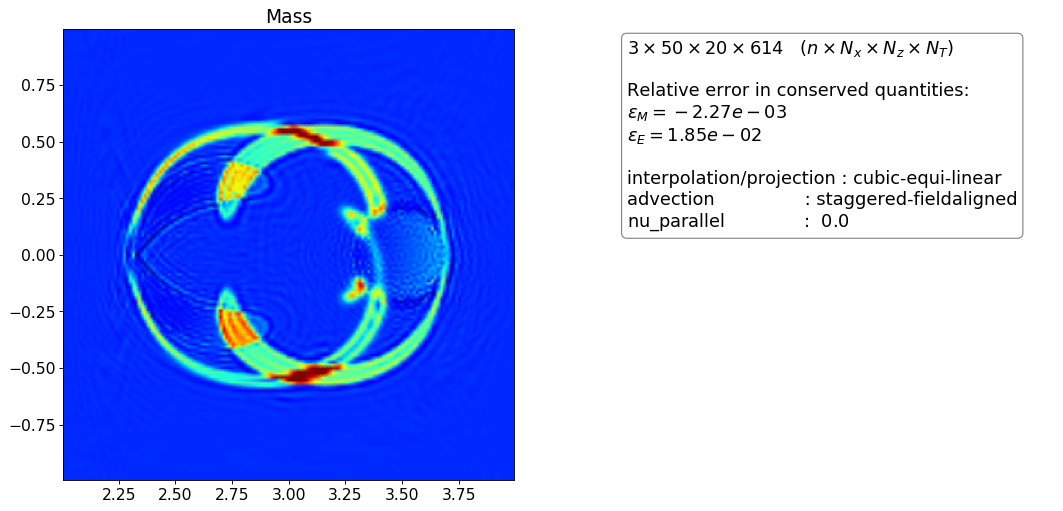

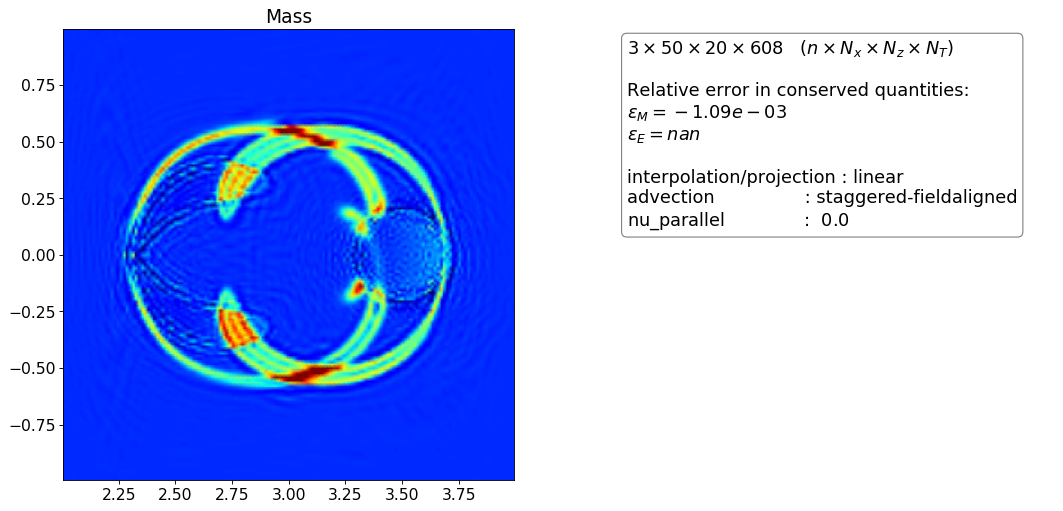

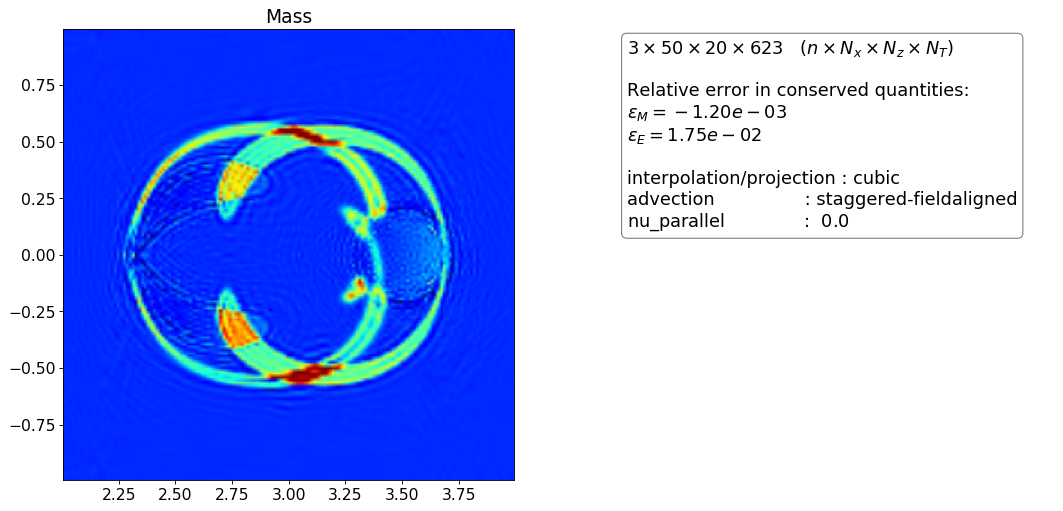

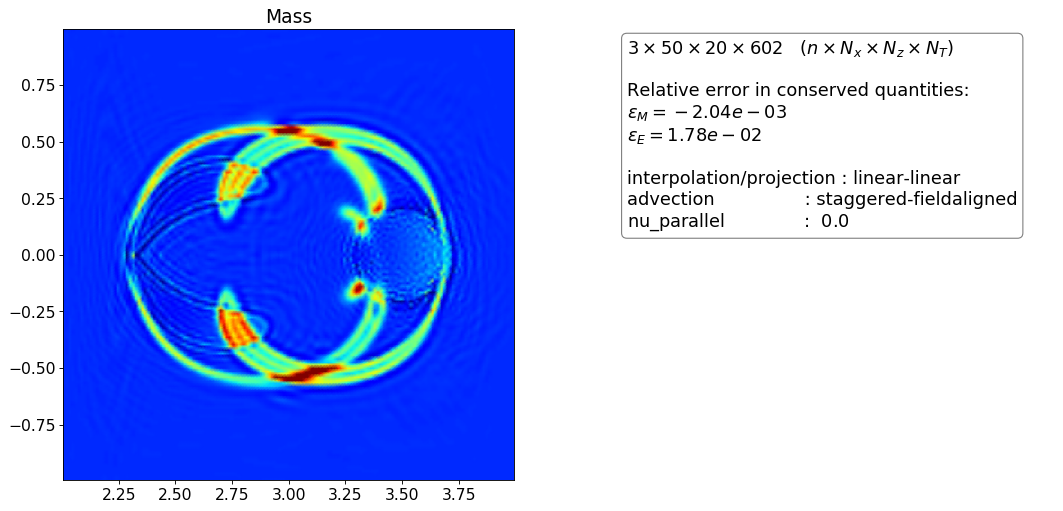

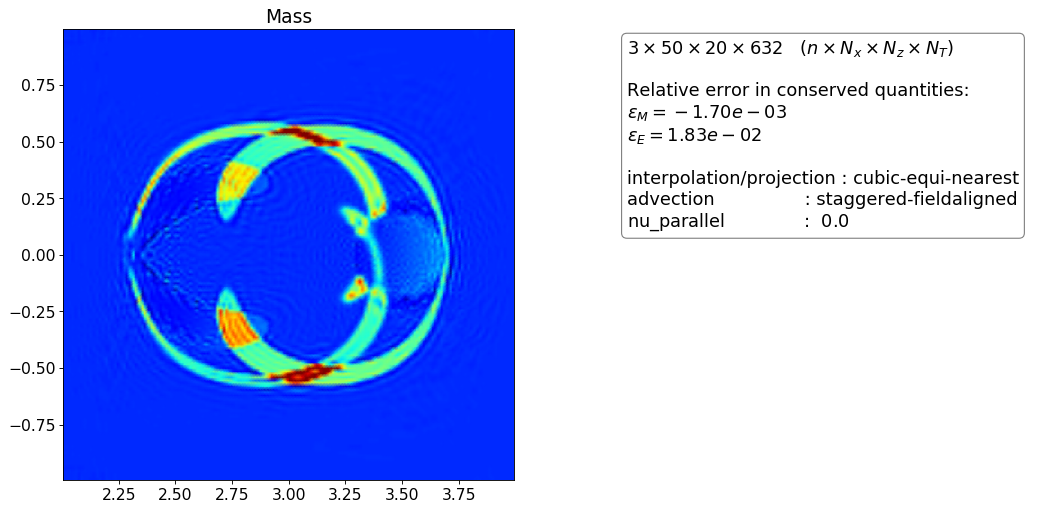

In [21]:
for nu in [0]:
    for p in {"linear", "cubic", "linear-nearest", "linear-linear", "linear-equi-nearest",
              "cubic-nearest", "cubic-equi-nearest", "cubic-linear", "cubic-equi-linear"
             } :
        for m in {"-fieldaligned"}:
            simulationfile = create_inputfile()
            simulationfile["flags"] = []
            simulationfile["FCI"]["interpolation-method"] = p
            simulationfile["FCI"]["refine"] = [5,5]
            
            if nu != 0:
                simulationfile["advection"]["type"] = "velocity-staggered"+m
            else:
                simulationfile["advection"]["type"] = "staggered"+m
            simulationfile["advection"]["slope-limiter"] = "none"
            
            simulationfile["physical"]["nu_parallel"] = [0,nu]
            simulationfile["grid"]["n"] = 3
            simulationfile["grid"]["Nx"] = 50
            simulationfile["grid"]["Ny"] = 50
            simulationfile["grid"]["Nz"] = 20
                
           
            simulationfile["timestepper"]["Tend"] = 40
            simulationfile["regularization"]["type"] = "none"
            
            simulationfile["init"]["density"]["ntilde"]["parallel"]="double-step"
            simulationfile["init"]["density"]["ntilde"]["type"]="circle"
            simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
            plot2d( simulationfile, False)

In [22]:
for nu in [0.2]:
    for p in {"linear-nearest", "linear-linear", "linear-equi-nearest",
              "cubic-nearest", "cubic-equi-nearest", "cubic-linear", "cubic-equi-linear"
             } :
        for m in {"-fieldaligned"}:
            simulationfile = create_inputfile()
            simulationfile["flags"] = []
            simulationfile["FCI"]["interpolation-method"] = p
            simulationfile["FCI"]["refine"] = [5,5]
            
            if nu != 0:
                simulationfile["advection"]["type"] = "velocity-staggered"+m
            else:
                simulationfile["advection"]["type"] = "staggered"+m
            simulationfile["advection"]["slope-limiter"] = "none"
            
            simulationfile["physical"]["nu_parallel"] = [0,nu]
            simulationfile["grid"]["n"] = 3
            simulationfile["grid"]["Nx"] = 50
            simulationfile["grid"]["Ny"] = 50
            simulationfile["grid"]["Nz"] = 20
                
           
            simulationfile["timestepper"]["Tend"] = 40
            simulationfile["regularization"]["type"] = "none"
            
            simulationfile["init"]["density"]["ntilde"]["parallel"]="double-step"
            simulationfile["init"]["density"]["ntilde"]["type"]="circle"
            simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
            plot2d( simulationfile, False)

ValueError: Entry does not exist

On the diffusion problem:
- direct diffusion operator is unstable without support operator
- direct diffusion operator is stable with support operator